In [1]:
!pip install pandas_ta
!pip install neat-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=c41efd9e8a7e21f7cb05781aa748e9e90d00ccf3d57735f50da2a818a430cf8a
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
use_collab = True
if use_collab:
  csv_dir = '/content/drive/MyDrive/eurusd_hour.csv'
  config_dir = '/content/drive/MyDrive/config-feedforward'
else:
  csv_dir = '/tmp/eurusd_hour.csv'
  config_dir = '/tmp/config-feedforward'

In [4]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import random
import neat
import string

In [5]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [6]:
df = pd.read_csv(csv_dir)
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


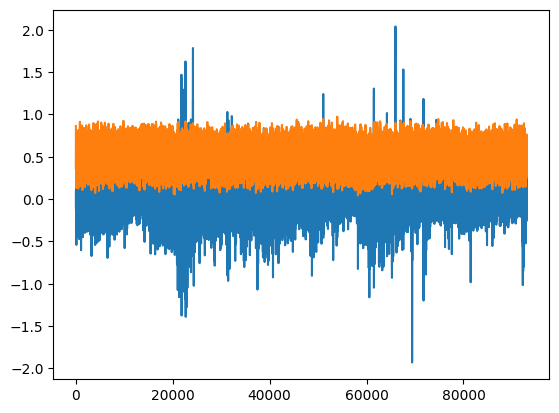

In [127]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [8]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [9]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [10]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [11]:
def run_env_loop(net,rand,debug):
    trade_info = np.zeros(4)
    returns = np.array([])

    trade_timer = 0
    trade_value = 0
    trade_direction = 0
    trade_max = 0
    cash_out_val = 0


    for count in range(rand, rand+1000):
        state = np.concatenate((INDICATORS[count], trade_info))
        outputs = net.activate(state)
        action = np.argmax(outputs)
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count]

        if buy or sell:
          cash_out_value = trade_value
          trade_direction = 1 if buy else -1
          trade_value = ((cur_move*trade_direction)-.1)
          trade_max = trade_value
          trade_timer = 0
        elif cash_out:
          cash_out_value = trade_value
          trade_direction = 0
          trade_value = 0
          trade_max = 0
          trade_timer = 0
        else:
          cash_out_value = 0
          trade_value += cur_move*trade_direction if trade_direction != 0 else 0
          trade_max = max(trade_max,trade_value)
          trade_timer += .1


        trade_info = np.array((trade_direction,trade_value,trade_timer,trade_max))

        if cash_out_value != 0:
            returns = np.append(returns,cash_out_value)
        if debug:
          print(trade_info)
          print(cash_out_value)

    return np.sum(returns) if len(returns)>1 else 0

In [70]:
def run_env_loop(net,rand,debug):
    profit = 0

    for count in range(rand, rand+1000):
        outputs = net.activate(INDICATORS[count])
        action = np.argmax(outputs)

        if action == 1:
          profit += change[count+1]
        elif action == 2:
          profit += change[count+1]*-1
        else:
          profit += 0

        if debug:
          print([action,profit])


    return profit

In [128]:
def eval_genomes(genomes, config):
  rand = random.randint(0, 70000)
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False)


In [131]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_dir)

p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(False))
#p.add_reporter(neat.Checkpointer(100, 100,filename_prefix="/content/drive/MyDrive/neat/Neetcheckpoint/"))

In [ ]:
winner = p.run(eval_genomes,50)


 ****** Running generation 0 ****** 

Population's average fitness: -0.06076 stdev: 7.10140
Best fitness: 15.99104 - size: (3, 6) - species 1 - id 143
Average adjusted fitness: 0.558
Mean genetic distance 1.306, standard deviation 0.273
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 3.416 sec

 ****** Running generation 1 ****** 

Population's average fitness: 28.66312 stdev: 27.35170
Best fitness: 51.07369 - size: (3, 4) - species 1 - id 152
Average adjusted fitness: 0.768
Mean genetic distance 1.578, standard deviation 0.299
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 3.352 sec (3.384 average)

 ****** Running generation 2 ****** 

Population's average fitness: -62.18488 stdev: 63.99794
Best fitness: 131.33843 - size: (4, 6) - species 1 - id 342
Average adjusted fitness: 0.314
Mean genetic distance 1.731, standard deviation 0.390
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 2.708 sec (3.15

In [119]:
net = neat.nn.FeedForwardNetwork.create(winner, config)

In [120]:
run_env_loop(net,70000,True)

[2, -0.7988013867545268]
[2, -1.7002730762560678]
[0, -1.7002730762560678]
[0, -1.7002730762560678]
[2, -4.371449538663226]
[0, -4.371449538663226]
[0, -4.371449538663226]
[0, -4.371449538663226]
[0, -4.371449538663226]
[0, -4.371449538663226]
[0, -4.371449538663226]
[0, -4.371449538663226]
[0, -4.371449538663226]
[0, -4.371449538663226]
[2, -3.550107183066942]
[2, -3.2271135017175343]
[2, -3.8219497710847987]
[2, -3.5944613797869844]
[2, -3.513717295750123]
[2, -4.071640441663526]
[2, -4.122993165388708]
[2, -3.521470351916766]
[2, -3.036962483138038]
[2, -3.3601586629218314]
[2, -2.677308561000283]
[2, -3.853083396747495]
[2, -3.0165431241846656]
[2, -2.4362434820703345]
[2, -3.06105861410185]
[2, -3.2299975325030172]
[2, -3.41358897366582]
[2, -3.802715720623429]
[2, -3.50183590070605]
[2, -3.281599137224241]
[2, -3.4211198873970243]
[2, -3.252255074962317]
[2, -3.0613251050485233]
[2, -3.0245992532220973]
[2, -3.208236735713258]
[2, -3.230268300480187]
[2, -3.6121384980987443]
[2, 

-16.31794548409005

In [121]:


def get_weights(connections, node_name,letter):
    node_weight = ""

    for key, value in connections.items():
        if value.enabled:
            if node_name == letter[value.key[1]]:
                if value.key[0] < 0:
                    from_node_name = "P" + str(value.key[0] * -1)
                    weight = value.weight
                else:
                    from_node_name = letter[value.key[0]]
                    weight = value.weight
                node_weight = node_weight + from_node_name + " * " + str(weight) + " + "


    return(node_weight)





In [122]:
nodes = winner.nodes
conec = winner.connections
node_list = []
letter_dict = dict()
count = 0



for index, node in nodes.items():
    letter_dict[index] = string.ascii_uppercase[count]
    count += 1

for index, node in nodes.items():
    node_name = letter_dict[index]
    activation = node.activation
    bias = str(node.bias) + ")"
    front = node_name + " = " + activation + "("
    weights = get_weights(conec,node_name,letter_dict)
    node_list.append((front+weights+bias))

node_list.reverse()






In [123]:
print(winner)

Key: 8623
Fitness: 26.618898487439225
Nodes:
	0 DefaultNodeGene(key=0, bias=1.5395215635276593, response=1.0, activation=relu, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.2989134187066093, response=1.0, activation=relu, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=1.6633835276755975, response=1.0, activation=relu, aggregation=sum)
	544 DefaultNodeGene(key=544, bias=0.9927853204629489, response=1.0, activation=relu, aggregation=sum)
	883 DefaultNodeGene(key=883, bias=-0.6695065056473692, response=1.0, activation=relu, aggregation=sum)
	1152 DefaultNodeGene(key=1152, bias=-0.9322944666236594, response=1.0, activation=relu, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-2, 883), weight=-0.6542039710558953, enabled=True)
	DefaultConnectionGene(key=(-1, 2), weight=-0.9674586412937529, enabled=True)
	DefaultConnectionGene(key=(-1, 1152), weight=-0.6524376858219811, enabled=True)
	DefaultConnectionGene(key=(1152, 0), weight=1.2911355095525834, enabled=True)
	DefaultConnec

In [124]:
for item in node_list:
       print(item)

F = relu(P1 * -0.6524376858219811 + -0.9322944666236594)
E = relu(P2 * -0.6542039710558953 + -0.6695065056473692)
D = relu(0.9927853204629489)
C = relu(P1 * -0.9674586412937529 + 1.6633835276755975)
B = relu(F * -0.8241958028233405 + 0.2989134187066093)
A = relu(F * 1.2911355095525834 + 1.5395215635276593)
